In [1]:
import numpy as np
import tools as tl

### Global Variables

In [2]:
# Real kind
RKD = np.float64  # double precision

# Constants
PI = np.pi  # Pi
SMV = np.finfo(float).eps  # Machien epsilon for float

# Global variables (simulating module-level scope)
cfl = 0.95
iter = 0  # Number of iteration
sim_time = 0.0  # Simulation time
max_time = 250  # Maximum simulation time

# output method
ORIGINAL = 0  # do not normalize the solution
NORMALIZE = 1  # normalize the solution
method_output = NORMALIZE

# Gas properties
ck = 2
gam = tl.get_gamma(ck)
pr = 2.0 / 3.0
omega = 0.72
kn = 1.0
alpha_ref = 1.0
omega_ref = 0.5
mu_ref = tl.get_mu(kn, alpha_ref, omega_ref) 

# I/O
HSTFILENAME = "shock.hst"  # history file name
RSTFILENAME = "shock.dat"  # result file name
HSTFILE = 20  # history file ID
RSTFILE = 21  # result file ID

# Velocity space
unum = 100
umin = -15.0
umax = +15.0
uspace, weight = tl.init_velocity_newton(unum, umin, umax)

# Geometry
xlength = 50.0
xscale = 0.5
xnum, dx = tl.init_geometry(xlength, xscale)

# Cell indices
ixmin = 0
ixmax = xnum

# Solution arrays
ctr, vface = tl.init_allocation(ixmin, ixmax, dx, unum)

# Mach number
Ma = 8.0

### Set Initial Condition

In [3]:
def init_flow_field(Ma_L):

    # upstream condition (before shock)
    prim_L = np.array([1.0, Ma_L * np.sqrt(gam / 2.0), 1.0], dtype=RKD)

    # downstream condition (after shock)
    Ma_R = np.sqrt((Ma_L**2 * (gam-1) + 2) / (2 * gam * Ma_L**2 - (gam - 1)))
    ratio_T = (1 + (gam-1) / 2 * Ma_L**2) * (2 * gam / (gam-1) * Ma_L**2 - 1) / (Ma_L**2 * (2 * gam / (gam-1) + (gam-1) / 2))
    
    prim_R = np.array([prim_L[0] * (gam+1) * Ma_L**2 / ((gam-1) * Ma_L**2 + 2),
                       Ma_R * np.sqrt(gam / 2.0) * np.sqrt(ratio_T),
                       prim_L[2] / ratio_T], dtype=RKD)

    w_L = tl.get_conserved(gam, prim_L)
    w_R = tl.get_conserved(gam, prim_R)
    H_L, B_L = tl.discrete_maxwell(prim_L, uspace, ck)
    H_R, B_R = tl.discrete_maxwell(prim_R, uspace, ck)

    for i in range(ixmin - 1, (ixmin + ixmax) // 2 + 1):
        ctr[i]['w'] = w_L
        ctr[i]['h'] = H_L
        ctr[i]['b'] = B_L

    for i in range((ixmin + ixmax) // 2 + 1, ixmax + 2):
        ctr[i]['w'] = w_R
        ctr[i]['h'] = H_R
        ctr[i]['b'] = B_R

    ctr[ixmin - 1]['sh'] = 0.0
    ctr[ixmin - 1]['sb'] = 0.0
    ctr[ixmax + 1]['sh'] = 0.0
    ctr[ixmax + 1]['sb'] = 0.0

### Gradient Interpolation

In [4]:
def timestep(ctr, ixmin, ixmax, umax, cfl):
    tmax = 0.0
    for i in range(ixmin, ixmax + 1):
        prim = tl.get_primary(gam, ctr[i]['w'])
        c = tl.get_sos(gam, prim)
        u = max(umax, np.abs(prim[1]))
        dx = ctr[i]['length']
        tmax = max(tmax, (u + c) / dx)
        
    # Return the time step, dt
    return cfl / tmax

def interpolation(ctr, ixmin, ixmax):
    tl.interp_boundary(ctr[ixmin], ctr[ixmin], ctr[ixmin + 1])
    tl.interp_boundary(ctr[ixmax], ctr[ixmax - 1], ctr[ixmax])
    for i in range(ixmin + 1, ixmax):
        tl.interp_inner(ctr[i - 1], ctr[i], ctr[i + 1])

def compute_fluxes(ctr, vface, ixmin, ixmax):
    for i in range(ixmin, ixmax + 2):  # ixmax+1 in Fortran becomes ixmax+2 in Python (arrays are 0-indexed)
        calc_flux(ctr[i - 1], vface[i], ctr[i])

def update(ctr, vface, ixmin, ixmax, dt):
    for i in range(ixmin, ixmax + 1):
        # H_old = np.zeros(unum, dtype=RKD)
        # B_old = np.zeros(unum, dtype=RKD)
        # H = np.zeros(unum, dtype=RKD)
        # B = np.zeros(unum, dtype=RKD)
        # H_plus = np.zeros(unum, dtype=RKD)
        # B_plus = np.zeros(unum, dtype=RKD)
        
        prim_old = tl.get_primary(ctr[i].w)
        H_old, B_old = tl.discrete_maxwell(prim_old, uspace, ck)
        tau_old = tl.get_tau(prim_old)
        
        ctr[i].w += (vface[i].flux - vface[i + 1].flux) / ctr[i].length
        
        prim = tl.get_primary(ctr[i].w)
        H, B = tl.discrete_maxwell(prim, uspace, ck)
        tau = tl.get_tau(prim)
        
        qf = tl.get_heat_flux(ctr[i].h, ctr[i].b, prim_old)
        
        H_plus, B_plus = tl.shakhov_part(H_old, B_old, qf, prim_old)
        H_old += H_plus
        B_old += B_plus
        
        H_plus, B_plus = tl.shakhov_part(H, B, qf, prim)
        H += H_plus
        B += B_plus
        
        ctr[i].h = (ctr[i].h + (vface[i].flux_h - vface[i + 1].flux_h) / ctr[i].length +
                    0.5 * dt * (H / tau + (H_old - ctr[i].h) / tau_old)) / (1.0 + 0.5 * dt / tau)
        
        ctr[i].b = (ctr[i].b + (vface[i].flux_b - vface[i + 1].flux_b) / ctr[i].length +
                    0.5 * dt * (B / tau + (B_old - ctr[i].b) / tau_old)) / (1.0 + 0.5 * dt / tau)

In [5]:
# Set flow initial condition
init_flow_field(Ma)

# Calculate time step
dt = timestep(ctr, ixmin, ixmax, umax, cfl)
print(dt)

# compute slopes of distribution functions
interpolation(ctr, ixmin, ixmax)

# Compute fluxes
compute_fluxes(ctr, vface, ixmin, ixmax)


0.02477760331953157


In [6]:
from scipy.special import erfc

def micro_slope(prim, sw):
    """
    Calculate micro slope of Maxwellian distribution.

    Parameters:
    prim (np.ndarray): Primary variables.
    sw (np.ndarray): Slope of W.

    Returns:
    np.ndarray: Slope of Maxwellian distribution.
    """
    micro_slope = np.zeros(3)
    ck = 2  # Constant

    micro_slope[2] = 4.0 * prim[2]**2 / (ck + 1) / prim[0] * (2.0 * sw[2] - 2.0 * prim[1] * sw[1] + sw[0] * (prim[1]**2 - 0.5 * (ck + 1) / prim[2]))
    micro_slope[1] = 2.0 * prim[2] / prim[0] * (sw[1] - prim[1] * sw[0]) - prim[1] * micro_slope[2]
    micro_slope[0] = sw[0] / prim[0] - prim[1] * micro_slope[1] - 0.5 * (prim[1]**2 + 0.5 * (ck + 1) / prim[2]) * micro_slope[2]

    return micro_slope

def calc_moment_u(prim, Mu, Mxi, Mu_L, Mu_R):
    """
    Calculate moments of velocity.

    Parameters:
    prim (np.ndarray): Primary variables.
    Mu (np.ndarray): <u^n>.
    Mxi (np.ndarray): <ξ^l>.
    Mu_L (np.ndarray): <u^n>_{>0}.
    Mu_R (np.ndarray): <u^n>_{<0}.

    Returns:
    None
    """
    MNUM = 10
    Mu_L[0] = 0.5 * erfc(-np.sqrt(prim[2]) * prim[1])
    Mu_L[1] = prim[1] * Mu_L[0] + 0.5 * np.exp(-prim[2] * prim[1]**2) / np.sqrt(np.pi * prim[2])
    Mu_R[0] = 0.5 * erfc(np.sqrt(prim[2]) * prim[1])
    Mu_R[1] = prim[1] * Mu_R[0] - 0.5 * np.exp(-prim[2] * prim[1]**2) / np.sqrt(np.pi * prim[2])

    for i in range(2, MNUM + 1):
        Mu_L[i] = prim[1] * Mu_L[i-1] + 0.5 * (i-1) * Mu_L[i-2] / prim[2]
        Mu_R[i] = prim[1] * Mu_R[i-1] + 0.5 * (i-1) * Mu_R[i-2] / prim[2]

    Mu = Mu_L + Mu_R

    Mxi[0] = 1.0  # <ξ^0>
    Mxi[1] = 0.5 * 2 / prim[2]  # <ξ^2>
    Mxi[2] = (2**2 + 2 * 2) / (4.0 * prim[2]**2)  # <ξ^4>

def moment_uv(Mu, Mxi, alpha, delta):
    """
    Calculate <u^α*ξ^δ*ψ>.

    Parameters:
    Mu (np.ndarray): <u^α>.
    Mxi (np.ndarray): <ξ^l>.
    alpha (int): Exponential index of u.
    delta (int): Exponential index of ξ.

    Returns:
    np.ndarray: Moment of <u^α*ξ^δ*ψ>.
    """
    moment_uv = np.zeros(3)
    moment_uv[0] = Mu[alpha] * Mxi[delta // 2]
    moment_uv[1] = Mu[alpha + 1] * Mxi[delta // 2]
    moment_uv[2] = 0.5 * (Mu[alpha + 2] * Mxi[delta // 2] + Mu[alpha] * Mxi[(delta + 2) // 2])
    return moment_uv

def moment_au(a, Mu, Mxi, alpha):
    """
    Calculate <a*u^α*ψ>.

    Parameters:
    a (np.ndarray): Micro slope of Maxwellian.
    Mu (np.ndarray): <u^α>.
    Mxi (np.ndarray): <ξ^l>.
    alpha (int): Exponential index of u.

    Returns:
    np.ndarray: Moment of <a*u^α*ψ>.
    """
    moment_au = a[0] * moment_uv(Mu, Mxi, alpha + 0, 0) + \
                a[1] * moment_uv(Mu, Mxi, alpha + 1, 0) + \
                0.5 * a[2] * moment_uv(Mu, Mxi, alpha + 2, 0) + \
                0.5 * a[2] * moment_uv(Mu, Mxi, alpha + 0, 2)
    return moment_au



ImportError: cannot import name 'sqrt' from 'scipy.special' (/Users/manuel/miniconda3/lib/python3.10/site-packages/scipy/special/__init__.py)

### Flux function

In [ ]:
def calc_flux(cell_L, face, cell_R):
                                                 
    # Heaviside step function
    delta = (np.sign(uspace) + 1) / 2

    # Reconstruct initial distribution
    h = (cell_L['h'] + 0.5 * cell_L['length'] * cell_L['sh']) * delta + \
        (cell_R['h'] - 0.5 * cell_R['length'] * cell_R['sh']) * (1 - delta)
    b = (cell_L['b'] + 0.5 * cell_L['length'] * cell_L['sb']) * delta + \
        (cell_R['b'] - 0.5 * cell_R['length'] * cell_R['sb']) * (1 - delta)
    sh = cell_L.sh * delta + cell_R.sh * (1 - delta)
    sb = cell_L.sb * delta + cell_R.sb * (1 - delta)

    # Calculate conservative variables w_0
    w = np.zeros(3)
    w[0] = np.sum(weight * h)
    w[1] = np.sum(weight * uspace * h)
    w[2] = 0.5 * (np.sum(weight * uspace**2 * h) + np.sum(weight * b))

    # Convert to primary variables
    prim = tl.get_primary(gam, w)

    # Heat flux
    qf = tl.get_heat_flux(h, b, prim, uspace, weight)

    # Calculate slopes a^L, a^R
    sw = (w - cell_L.w) / (0.5 * cell_L.length)  # left slope of W
    aL = micro_slope(prim, sw)  # calculate a^L

    sw = (cell_R.w - w) / (0.5 * cell_R.length)  # right slope of W
    aR = micro_slope(prim, sw)  # calculate a^R

    # Calculate time slope of W and A
    # <u^n>,<\xi^l>,<u^n>_{>0},<u^n>_{<0}
    calc_moment_u(prim, Mu, Mxi, Mu_L, Mu_R)

    Mau_L = moment_au(aL, Mu_L, Mxi, 1)  # <aL*u*psi>_{>0}
    Mau_R = moment_au(aR, Mu_R, Mxi, 1)  # <aR*u*psi>_{<0}

    sw = -prim[0] * (Mau_L + Mau_R)  # time slope of W
    aT = micro_slope(prim, sw)  # calculate A

    # Calculate collision time and some time integration terms
    tau = tl.get_tau(mu_ref, omega, prim)

    Mt = np.zeros(6)
    Mt[3] = tau * (1.0 - np.exp(-dt / tau))
    Mt[4] = -tau * dt * np.exp(-dt / tau) + tau * Mt[3]
    Mt[1] = dt - Mt[3]
    Mt[2] = -tau * Mt[1] + Mt[4]
    Mt[5] = dt**2 / 2.0 - tau * Mt[1]

    # Calculate flux of conservative variables related to g0
    Mau_0 = moment_uv(Mu, Mxi, 1, 0)  # <u*psi>
    Mau_L = moment_au(aL, Mu_L, Mxi, 2)  # <aL*u^2*psi>_{>0}
    Mau_R = moment_au(aR, Mu_R, Mxi, 2)  # <aR*u^2*psi>_{<0}
    Mau_T = moment_au(aT, Mu, Mxi, 1)  # <A*u*psi>

    face.flux = (Mt[1] * prim[0] * Mau_0 +
                 Mt[2] * prim[0] * (Mau_L + Mau_R) +
                 Mt[3] * prim[0] * Mau_T)

    # Calculate flux of conservative variables related to g+ and f0
    H0, B0 = tl.discrete_maxwell(prim, uspace, ck)
    H_plus, B_plus = tl.shakhov_part(H0, B0, qf, prim, uspace, ck)

    face.flux[0] += (Mt[1] * np.sum(weight * uspace * H_plus) +
                     Mt[4] * np.sum(weight * uspace * h) -
                     Mt[5] * np.sum(weight * uspace**2 * sh))

    face.flux[1] += (Mt[1] * np.sum(weight * uspace**2 * H_plus) +
                     Mt[4] * np.sum(weight * uspace**2 * h) -
                     Mt[5] * np.sum(weight * uspace**3 * sh))

    face.flux[2] += (Mt[1] * 0.5 * (np.sum(weight * uspace * uspace**2 * H_plus) +
                                    np.sum(weight * uspace * B_plus)) +
                     Mt[4] * 0.5 * (np.sum(weight * uspace**2 * uspace**2 * h) +
                                    np.sum(weight * uspace**2 * sb)))

    # Calculate flux of distribution function
    face.flux_h = (Mt[1] * uspace * (H0 + H_plus) +
                   Mt[2] * uspace**2 * (aL[0] * H0 + aL[1] * uspace * H0 + 0.5 * aL[2] * (uspace**2 * H0 + B0)) * delta +
                   Mt[2] * uspace**2 * (aR[0] * H0 + aR[1] * uspace * H0 + 0.5 * aR[2] * (uspace**2 * H0 + B0)) * (1 - delta) +
                   Mt[3] * uspace * (aT[0] * H0 + aT[1] * uspace * H0 + 0.5 * aT[2] * (uspace**2 * H0 + B0)) +
                   Mt[4] * uspace * h - Mt[5] * uspace**2 * sh)

    face.flux_b = (Mt[1] * uspace * (B0 + B_plus) +
                   Mt[2] * uspace**2 * (aL[0] * B0 + aL[1] * uspace * B0 + 0.5 * aL[2] * (uspace**2 * B0 + Mxi[1] * H0)) * delta +
                   Mt[2] * uspace**2 * (aR[0] * B0 + aR[1] * uspace * B0 + 0.5 * aR[2] * (uspace**2 * B0 + Mxi[1] * H0)) * (1 - delta) +
                   Mt[3] * uspace * (aT[0] * B0 + aT[1] * uspace * B0 + 0.5 * aT[2] * (uspace**2 * B0 + Mxi[1] * H0)) +
                   Mt[4] * uspace * b - Mt[5] * uspace**2 * sb)

### Main

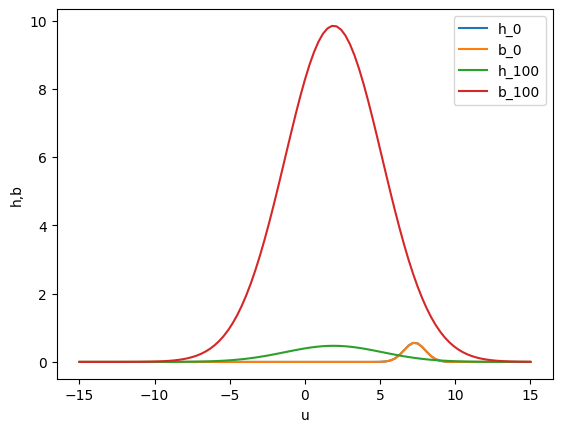

In [7]:
import matplotlib.pyplot as plt

# plot the initial distribution functions h and b
fig, ax = plt.subplots()
plt.plot(uspace, ctr[0]['h'], label='h_0')
plt.plot(uspace, ctr[0]['b'], label='b_0')
plt.plot(uspace, ctr[100]['h'], label='h_100')
plt.plot(uspace, ctr[100]['b'], label='b_100')
plt.xlabel('u')
plt.ylabel('h,b')
plt.legend()
plt.show()


In [ ]:
# Open file and write header
with open(HSTFILENAME, "w") as HSTFILE:
    HSTFILE.write("VARIABLES = iter, sim_time, dt\n")

    # Iteration loop
    while True:
        
        interpolation()  # Calculate the slope of distribution function
        evolution()  # Calculate flux across the interfaces
        update()  # Update cell averaged value

        # Check if output
        if sim_time >= max_time:
            break

        # Write iteration information every 10 iterations
        if iter % 10 == 0:
            print(f"iter,sim_time,dt: {iter:15d}{sim_time:15.7f}{dt:15.7f}")
            HSTFILE.write(f"{iter:15d}{sim_time:15.7f}{dt:15.7f}\n")

        iter += 1
        sim_time += dt

# Output solution
output(sim_time)